Примение уже обученной модели.

In [1]:
pip install torch_geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import os
import json
from torch_geometric.utils import dense_to_sparse
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS, DBSCAN
from tqdm.notebook import tqdm
from torch.utils.data import Dataset

# Custom imports
import sys
sys.path.insert(1, "/kaggle/input/second-dataset/dependecies")

import GCN
from Graph import Graph

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST = False

In [3]:
model_diversity_path = "/kaggle/input/second-dataset/weights/weights_models_cifar/model_diversity_weights.pth"
model_accuracy_path = "/kaggle/input/second-dataset/weights/weights_models_cifar/model_accuracy_weights.pth"

In [4]:
input_dim = 8
output_dim = 16
dropout=0

model_diverisity = GCN.GCN(input_dim, output_dim, dropout).to(device)
state_dict = torch.load(model_diversity_path, map_location=device, weights_only=True)
model_diverisity.load_state_dict(state_dict)
model_diverisity.eval()

GCN(
  (gc1): GCNConv(8, 64)
  (gc2): GCNConv(64, 256)
  (gc3): GCNConv(256, 512)
  (gc4): GCNConv(512, 64)
  (residual_proj): Linear(in_features=8, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
)

In [ ]:
input_dim = 8
output_dim = 1
dropout = 0

model_accuracy = GCN.GCN(input_dim, output_dim, dropout).to(device)
state_dict = torch.load(model_accuracy_path, map_location=device, weights_only=True)
model_accuracy.load_state_dict(state_dict)
model_accuracy.eval()

GCN(
  (gc1): GCNConv(8, 64)
  (gc2): GCNConv(64, 256)
  (gc3): GCNConv(256, 512)
  (gc4): GCNConv(512, 64)
  (residual_proj): Linear(in_features=8, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
def load_json_from_directory(directory_path):
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [7]:
if TEST:
    arch_dicts = load_json_from_directory("/kaggle/input/second-dataset/third_dataset")
else:
    architecture_path = "/kaggle/input/second-dataset"
    arch_dicts = load_json_from_directory(architecture_path)[0] # return array of dicts, but this json contains all dicts
    arch_dicts = [{"architecture": tmp_dict, "test_predictions":None} for tmp_dict in tqdm(arch_dicts)]

  0%|          | 0/500000 [00:00<?, ?it/s]

In [8]:
graph = Graph(arch_dicts[1])

In [9]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(arch_dicts)]

In [10]:
if TEST:
    accuracies = [arch_dict["test_accuracy"] for arch_dict in arch_dicts]
    dataset = GCN.CustomDataset(graphs, accuracies)
else:
    dataset = GCN.CustomDataset(graphs)

100%|██████████| 500000/500000 [19:00<00:00, 438.48it/s]


In [11]:
def extract_embeddings(model, dataset, device, use_tqdm=True):
    model.to(device)
    model.eval()
    embeddings = []
    indices = []

    iterator = tqdm(dataset) if use_tqdm else dataset

    with torch.no_grad():
        for data in iterator:
            if TEST:
                adj, features, index, _ = data
            else:
                adj, features, index = data

            adj = adj.to(device)
            features = features.to(device)

            edge_index, _ = dense_to_sparse(adj)

            embedding = model(features, edge_index)

            embeddings.append(embedding.cpu().numpy())
            indices.append(index)

    embeddings = np.vstack(embeddings)
    return embeddings, indices


def visualize_clusters(model, train_dataset, device="cpu", min_samples=3, eps=0.025):
    # Извлечение эмбеддингов
    embeddings, indices = extract_embeddings(model, train_dataset, device=device)
    
    # Преобразование эмбеддингов в 2D с помощью PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Кластеризация с помощью OPTICS
    # optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size, metric="euclidean")
    # clusters = optics.fit_predict(embeddings)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
    clusters = dbscan.fit_predict(embeddings)
    
    # Визуализация кластеров
    plt.figure(figsize=(8, 6.5))
    scatter = plt.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=clusters, 
        cmap='tab10',  
        s=np.where(clusters == -1, 20, 70),  
        alpha=np.where(clusters == -1, 0.5, 1)
    )
    plt.xlabel("PCA Component 1", fontsize=16)
    plt.ylabel("PCA Component 2", fontsize=16)
    
    # Создание легенды для кластеров
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        if cluster == -1:
          label = "Noise"
        else:
          label = f"Cluster {cluster}"
        plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label ,  s=50 if cluster != -1 else 20)
    
    plt.gca().set_facecolor('lightgrey')
    # plt.legend()
    plt.show()
    
    return clusters

Разобьем модели на кластеры. 

  0%|          | 0/500000 [00:00<?, ?it/s]

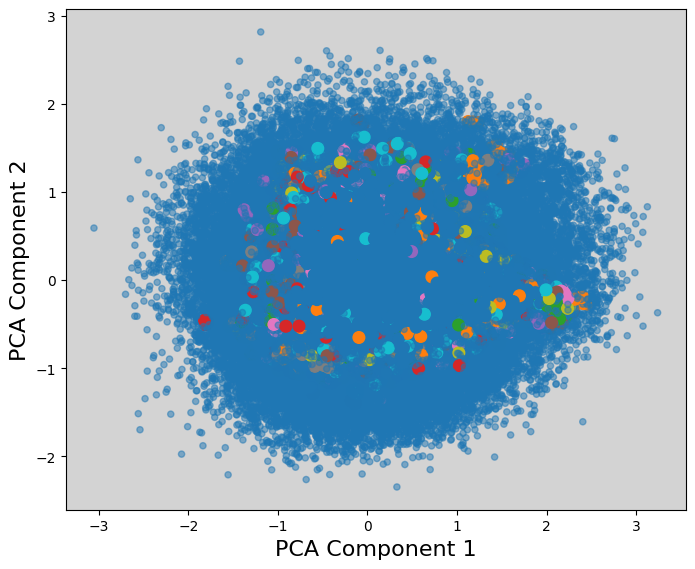

In [12]:
clusters = visualize_clusters(
  model_diverisity,
  dataset,
  device=device,
  min_samples=3,
  eps=0.1,
)

In [13]:
cluster_indexes = np.where(clusters == 0)[0]

In [14]:
max_cluster = np.max(clusters)
cluster_indexes = [np.where(clusters == i)[0] for i in range(max_cluster + 1)]

In [15]:
cluster_indexes = sorted(cluster_indexes, key=len, reverse=True)
cluster_indexes[:5]

[array([     0,      3,      4, ..., 499996, 499997, 499999]),
 array([  3029,   7426,  12299,  26309,  33817,  36088,  55416,  59616,
         61322,  67118,  75872,  76673,  83306,  85875,  86402,  95730,
        112029, 114045, 120393, 142070, 148359, 160899, 162598, 165838,
        166775, 173795, 177502, 200997, 205077, 206630, 219761, 224068,
        224478, 230129, 232198, 255593, 269440, 270689, 272275, 275557,
        277180, 279417, 279868, 280076, 293370, 317180, 319021, 324610,
        327978, 340073, 340461, 346177, 350035, 354359, 359182, 365531,
        367256, 373827, 378481, 382233, 391159, 393139, 393628, 396214,
        396414, 410456, 410827, 416696, 421015, 421597, 430186, 432949,
        437218, 442172, 448236, 451955, 461722, 462350, 462403, 485457,
        489339, 490770, 490790, 493884]),
 array([  5197,   8469,  14603,  21861,  54905,  55013,  58379,  67025,
         69889,  74268,  77086, 109659, 126107, 126771, 131869, 137206,
        182231, 262683, 264942,

Для каждого кластера найдем модель с наибольшей точностью

In [16]:
best_models = []
N_models = min(len(cluster_indexes), 20)

for indexes in  tqdm(cluster_indexes[1:N_models]):
    embeddings, indices = extract_embeddings(
    model_accuracy,
    dataset[indexes],
    device=device,
    use_tqdm=True
    )

    best_model_index = indices[np.argmax(embeddings)]
    if TEST:
        accuracies = [dataset[i][3] for i in indices]
        print(f"index: {indices[np.argmax(accuracies)]}, best_accuracy: {np.max(accuracies):.3f}")
        print(f"index: {best_model_index}, best_accuracy: {np.max(embeddings)}, real_acc: {dataset[best_model_index][3]:.3f}")
    best_models.append(arch_dicts[best_model_index]["architecture"])

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
def save_best_models(best_models, output_directory="best_models"):
    os.makedirs(output_directory, exist_ok=True)

    for i, model in enumerate(best_models):
        file_path = os.path.join(output_directory, f"model_{i}.json")
        with open(file_path, "w", encoding="utf-8") as f:
            json.dump(model, f, ensure_ascii=False, indent=4)

In [18]:
save_best_models(best_models)

In [19]:
!zip -r best_models.zip /kaggle/working/best_models

  adding: kaggle/working/best_models/ (stored 0%)
  adding: kaggle/working/best_models/model_0.json (deflated 83%)
  adding: kaggle/working/best_models/model_4.json (deflated 82%)
  adding: kaggle/working/best_models/model_18.json (deflated 83%)
  adding: kaggle/working/best_models/model_7.json (deflated 82%)
  adding: kaggle/working/best_models/model_13.json (deflated 84%)
  adding: kaggle/working/best_models/model_5.json (deflated 82%)
  adding: kaggle/working/best_models/model_11.json (deflated 83%)
  adding: kaggle/working/best_models/model_8.json (deflated 83%)
  adding: kaggle/working/best_models/model_3.json (deflated 82%)
  adding: kaggle/working/best_models/model_1.json (deflated 82%)
  adding: kaggle/working/best_models/model_12.json (deflated 81%)
  adding: kaggle/working/best_models/model_9.json (deflated 82%)
  adding: kaggle/working/best_models/model_2.json (deflated 82%)
  adding: kaggle/working/best_models/model_17.json (deflated 82%)
  adding: kaggle/working/best_model